# Predicting wine quality

### We have been provided with a dataset containing information about wine, and it's assigned quality. 
### The following analysis has been requested:
    1. Develop a model that best predicts wine quality.
    2. State the model that was chosen for the analysis.  Explain why you decided on this model?
    3. Identify the variables that are most important in predicting wine quality and quantify their importance to a business stakeholder in plain (non-technical) language. 
    
### Dataset available at: https://www.kaggle.com/uciml/red-wine-quality-cortez-et-al-2009 -------

In [541]:
#install and import packages

if (!require("pacman")) install.packages("pacman")
pacman::p_load(tidyverse, skimr, reshape2, GGally, ggplot2, plotly, caret, randomForest, rfPermute, plyr, caTools, corrgram, MASS, DMwR, UBL)

In [584]:
#read in dataset

wine <- read.csv('wine_data.txt', header = TRUE, sep = ";", dec = ".")

In [585]:
head(wine)

fixed.acidity volatile.acidity citric.acid residual.sugar chlorides
1  7.4          0.70             0.00        1.9            0.076    
2  7.8          0.88             0.00        2.6            0.098    
3  7.8          0.76             0.04        2.3            0.092    
4 11.2          0.28             0.56        1.9            0.075    
5  7.4          0.70             0.00        1.9            0.076    
6  7.4          0.66             0.00        1.8            0.075    
  free.sulfur.dioxide total.sulfur.dioxide density pH   sulphates alcohol
1 11                  34                   0.9978  3.51 0.56      9.4    
2 25                  67                   0.9968  3.20 0.68      9.8    
3 15                  54                   0.9970  3.26 0.65      9.8    
4 17                  60                   0.9980  3.16 0.58      9.8    
5 11                  34                   0.9978  3.51 0.56      9.4    
6 13                  40                   0.9978  3.51 0.56      9.4    
  quality
1 5      
2 5      
3 5      
4 6      
5 5      
6 5

In [586]:
#more as a preference thing than anything, I prefer to use '_' to seperate words in column names, so lets do that with gsub

names(wine) <- gsub(x = names(wine), pattern = "\\.", replacement = "_")

In [587]:
#make use of the skim package to look at summary statistics of the variables 

skim(wine) %>% skimr::kable()

Skim summary statistics  
 n obs: 1599    
 n variables: 12    

Variable type: integer

| variable | missing | complete |  n   | mean |  sd  | p0 | p25 | p50 | p75 | p100 |   hist   |
|----------|---------|----------|------|------|------|----|-----|-----|-----|------|----------|
| quality  |    0    |   1599   | 1599 | 5.64 | 0.81 | 3  |  5  |  6  |  6  |  8   | ▁▁▁▇▇▁▂▁ |

Variable type: numeric

|       variable       | missing | complete |  n   | mean  |   sd   |  p0   | p25  |  p50  | p75  | p100 |   hist   |
|----------------------|---------|----------|------|-------|--------|-------|------|-------|------|------|----------|
|       alcohol        |    0    |   1599   | 1599 | 10.42 |  1.07  |  8.4  | 9.5  | 10.2  | 11.1 | 14.9 | ▂▇▅▃▂▁▁▁ |
|      chlorides       |    0    |   1599   | 1599 | 0.087 | 0.047  | 0.012 | 0.07 | 0.079 | 0.09 | 0.61 | ▇▃▁▁▁▁▁▁ |
|     citric_acid      |    0    |   1599   | 1599 | 0.27  |  0.19  |   0   | 0.09 | 0.26  | 0.42 |  1   | ▇▅▅▆▂▁▁▁ |
|       

### We can see that there are no missing values, which is nice. 
### The values are in different ranges, so depending on which model strategy we want to go with, it might be necessary to standardize the data later. 
### Some of the features are fairly normally distrubuted, others have a lot of skew, there could potentially be outliers which we should investigate. 
### There are several different measures of acidity, we should look at them and see if they are related/correlated - again multicolinearity is an important consideration for model selection later
### There are 6 wine qualities listed, and they don't appear to be evenly distributed (we'll look at this in finer detail in the next cell), meaning we will have an imbalanced label/class problem when it comes to modeling the data


In [588]:
#the wine quality label is ordinal, so we want to convert it to a factor. As they are ordinal we should order them
wine$quality <- factor(wine$quality, ordered = TRUE)

In [589]:
cat('Table showing number of values for each quality measure')
table(wine$quality)

cat('\n\nTable showing percent representation for each quality measure')
table(wine$quality)/sum(table(wine$quality))*100

Table showing number of values for each quality measure


  3   4   5   6   7   8 
 10  53 681 638 199  18 



Table showing percent representation for each quality measure


         3          4          5          6          7          8 
 0.6253909  3.3145716 42.5891182 39.8999375 12.4452783  1.1257036 

## Dealing with duplicates
#### We should check for duplicates:

In [590]:
dim(wine[ which(duplicated(wine)),])

[1] 240  12

#### That is quite a lot of duplicated values. Lets look and see how it effects our class imbalance

In [591]:
print("Class/label breakdown in duplicated entries")
table(wine[ which(duplicated(wine)),]$quality)

[1] "Class/label breakdown in duplicated entries"



  3   4   5   6   7   8 
  0   0 104 103  32   1 

#### It doesn't seem to effect our smaller classes too much. In 'real-life' I would look at how the data were collected/recorded and try to identify somewhere where they could have been duplicated. That isn't possible here. The fact that there are exact duplicates when we hae a couple of features that are measured to 4 decimal places definitely seems suspect. Duplicate values will effect a predictive model later on, so I'm going to remove them. 

In [592]:
#remove duplicates

wine <- wine[!duplicated(wine),]

# reset index
row.names(wine) <- NULL

dim(wine)

[1] 1359   12

In [593]:
print("Class breakdown with duplicates removed")
table(wine$quality)

[1] "Class breakdown with duplicates removed"



  3   4   5   6   7   8 
 10  53 577 535 167  17 

In [594]:
skim(wine) %>% skimr::kable()

Skim summary statistics  
 n obs: 1359    
 n variables: 12    

Variable type: factor

| variable | missing | complete |  n   | n_unique |          top_counts           | ordered |
|----------|---------|----------|------|----------|-------------------------------|---------|
| quality  |    0    |   1359   | 1359 |    6     | 5: 577, 6: 535, 7: 167, 4: 53 |  TRUE   |

Variable type: numeric

|       variable       | missing | complete |  n   | mean  |   sd   |  p0   | p25  |  p50  |  p75  | p100 |   hist   |
|----------------------|---------|----------|------|-------|--------|-------|------|-------|-------|------|----------|
|       alcohol        |    0    |   1359   | 1359 | 10.43 |  1.08  |  8.4  | 9.5  | 10.2  | 11.1  | 14.9 | ▂▇▅▃▂▁▁▁ |
|      chlorides       |    0    |   1359   | 1359 | 0.088 | 0.049  | 0.012 | 0.07 | 0.079 | 0.091 | 0.61 | ▇▃▁▁▁▁▁▁ |
|     citric_acid      |    0    |   1359   | 1359 | 0.27  |  0.2   |   0   | 0.09 | 0.26  | 0.43  |  1   | ▇▅▅▆▂▁▁▁ |
|       de

## Adding a feature for EDA

In [595]:
# To add another level to the quality, mostly for visualization purposes, I am going to add a feature that has the wines categorised sa low, medium or high quality. 

wine$rating <- ifelse(wine$quality < 5, 'low', ifelse(wine$quality < 7, 'medium', 'high'))

wine$rating <- ordered(wine$rating, levels = c('low', 'medium', 'high'))

In [596]:
head(wine)

fixed_acidity volatile_acidity citric_acid residual_sugar chlorides
1  7.4          0.70             0.00        1.9            0.076    
2  7.8          0.88             0.00        2.6            0.098    
3  7.8          0.76             0.04        2.3            0.092    
4 11.2          0.28             0.56        1.9            0.075    
5  7.4          0.66             0.00        1.8            0.075    
6  7.9          0.60             0.06        1.6            0.069    
  free_sulfur_dioxide total_sulfur_dioxide density pH   sulphates alcohol
1 11                  34                   0.9978  3.51 0.56      9.4    
2 25                  67                   0.9968  3.20 0.68      9.8    
3 15                  54                   0.9970  3.26 0.65      9.8    
4 17                  60                   0.9980  3.16 0.58      9.8    
5 13                  40                   0.9978  3.51 0.56      9.4    
6 15                  59                   0.9964  3.30 0.46      9.4    
  quality rating
1 5       medium
2 5       medium
3 5       medium
4 6       medium
5 5       medium
6 5       medium

## Correlations


In [597]:
cormat <- round(cor(wine[1:10]),2)
melted_cormat <- melt(cormat)
head(melted_cormat)

Var1                Var2          value
1 fixed_acidity       fixed_acidity  1.00
2 volatile_acidity    fixed_acidity -0.26
3 citric_acid         fixed_acidity  0.67
4 residual_sugar      fixed_acidity  0.11
5 chlorides           fixed_acidity  0.09
6 free_sulfur_dioxide fixed_acidity -0.14

In [598]:
# Get lower triangle of the correlation matrix
get_lower_tri<-function(cormat){
   cormat[upper.tri(cormat)] <- NA
   return(cormat)
  }
# Get upper triangle of the correlation matrix
  get_upper_tri <- function(cormat){
    cormat[lower.tri(cormat)]<- NA
    return(cormat)
  }


In [599]:
upper_tri <- get_upper_tri(cormat)
# Melt the correlation matrix
melted_cormat <- melt(upper_tri, na.rm = TRUE)
# Create a ggheatmap
ggheatmap <- ggplot(melted_cormat, aes(Var2, Var1, fill = value))+
 geom_tile(color = "white")+
 scale_fill_gradient2(low = "blue", high = "red", mid = "white", 
   midpoint = 0, limit = c(-1,1), space = "Lab", 
    name="Pearson\nCorrelation") +
  theme_minimal()+ # minimal theme
 theme(axis.text.x = element_text(angle = 45, vjust = 1, 
    size = 12, hjust = 1))+
 coord_fixed()

png 
  6

png 
  2

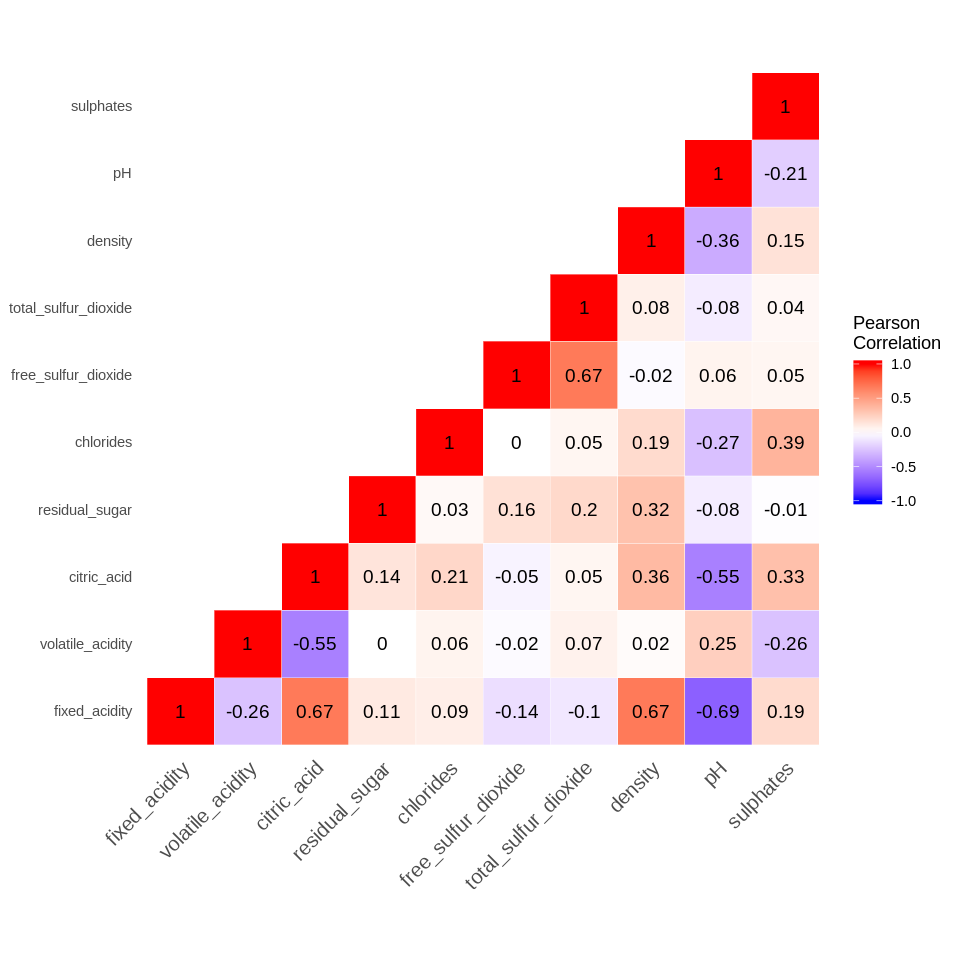

In [600]:
options(repr.plot.width = 8, repr.plot.height = 8)
ggheatmap + 
geom_text(aes(Var2, Var1, label = value), color = "black", size = 4) +
theme(
  axis.title.x = element_blank(),
  axis.title.y = element_blank(),
  panel.grid.major = element_blank(),
  panel.border = element_blank(),
  panel.background = element_blank(),
  axis.ticks = element_blank())

dev.copy(png,"Corr.png")
dev.off()

### There is a pretty strong positive correlation between density and fixed acity, between citric acid and fixed acidity, and also between free sulfur dioxide and total sulphur dioxide (that one was probably expected). There is a negative correlation between pH and both fixed acidity and citric acid (again, that could be expected as acidity will lower the pH). There is also a negative correlation between citric acid and volitile acidity. These correlations are important to consider if we plan on using a model that requires little/no multicollinearity later on. 

## Paired plots to get an overview of the relationship between different wine features and their quality

png 
  6

png 
  2

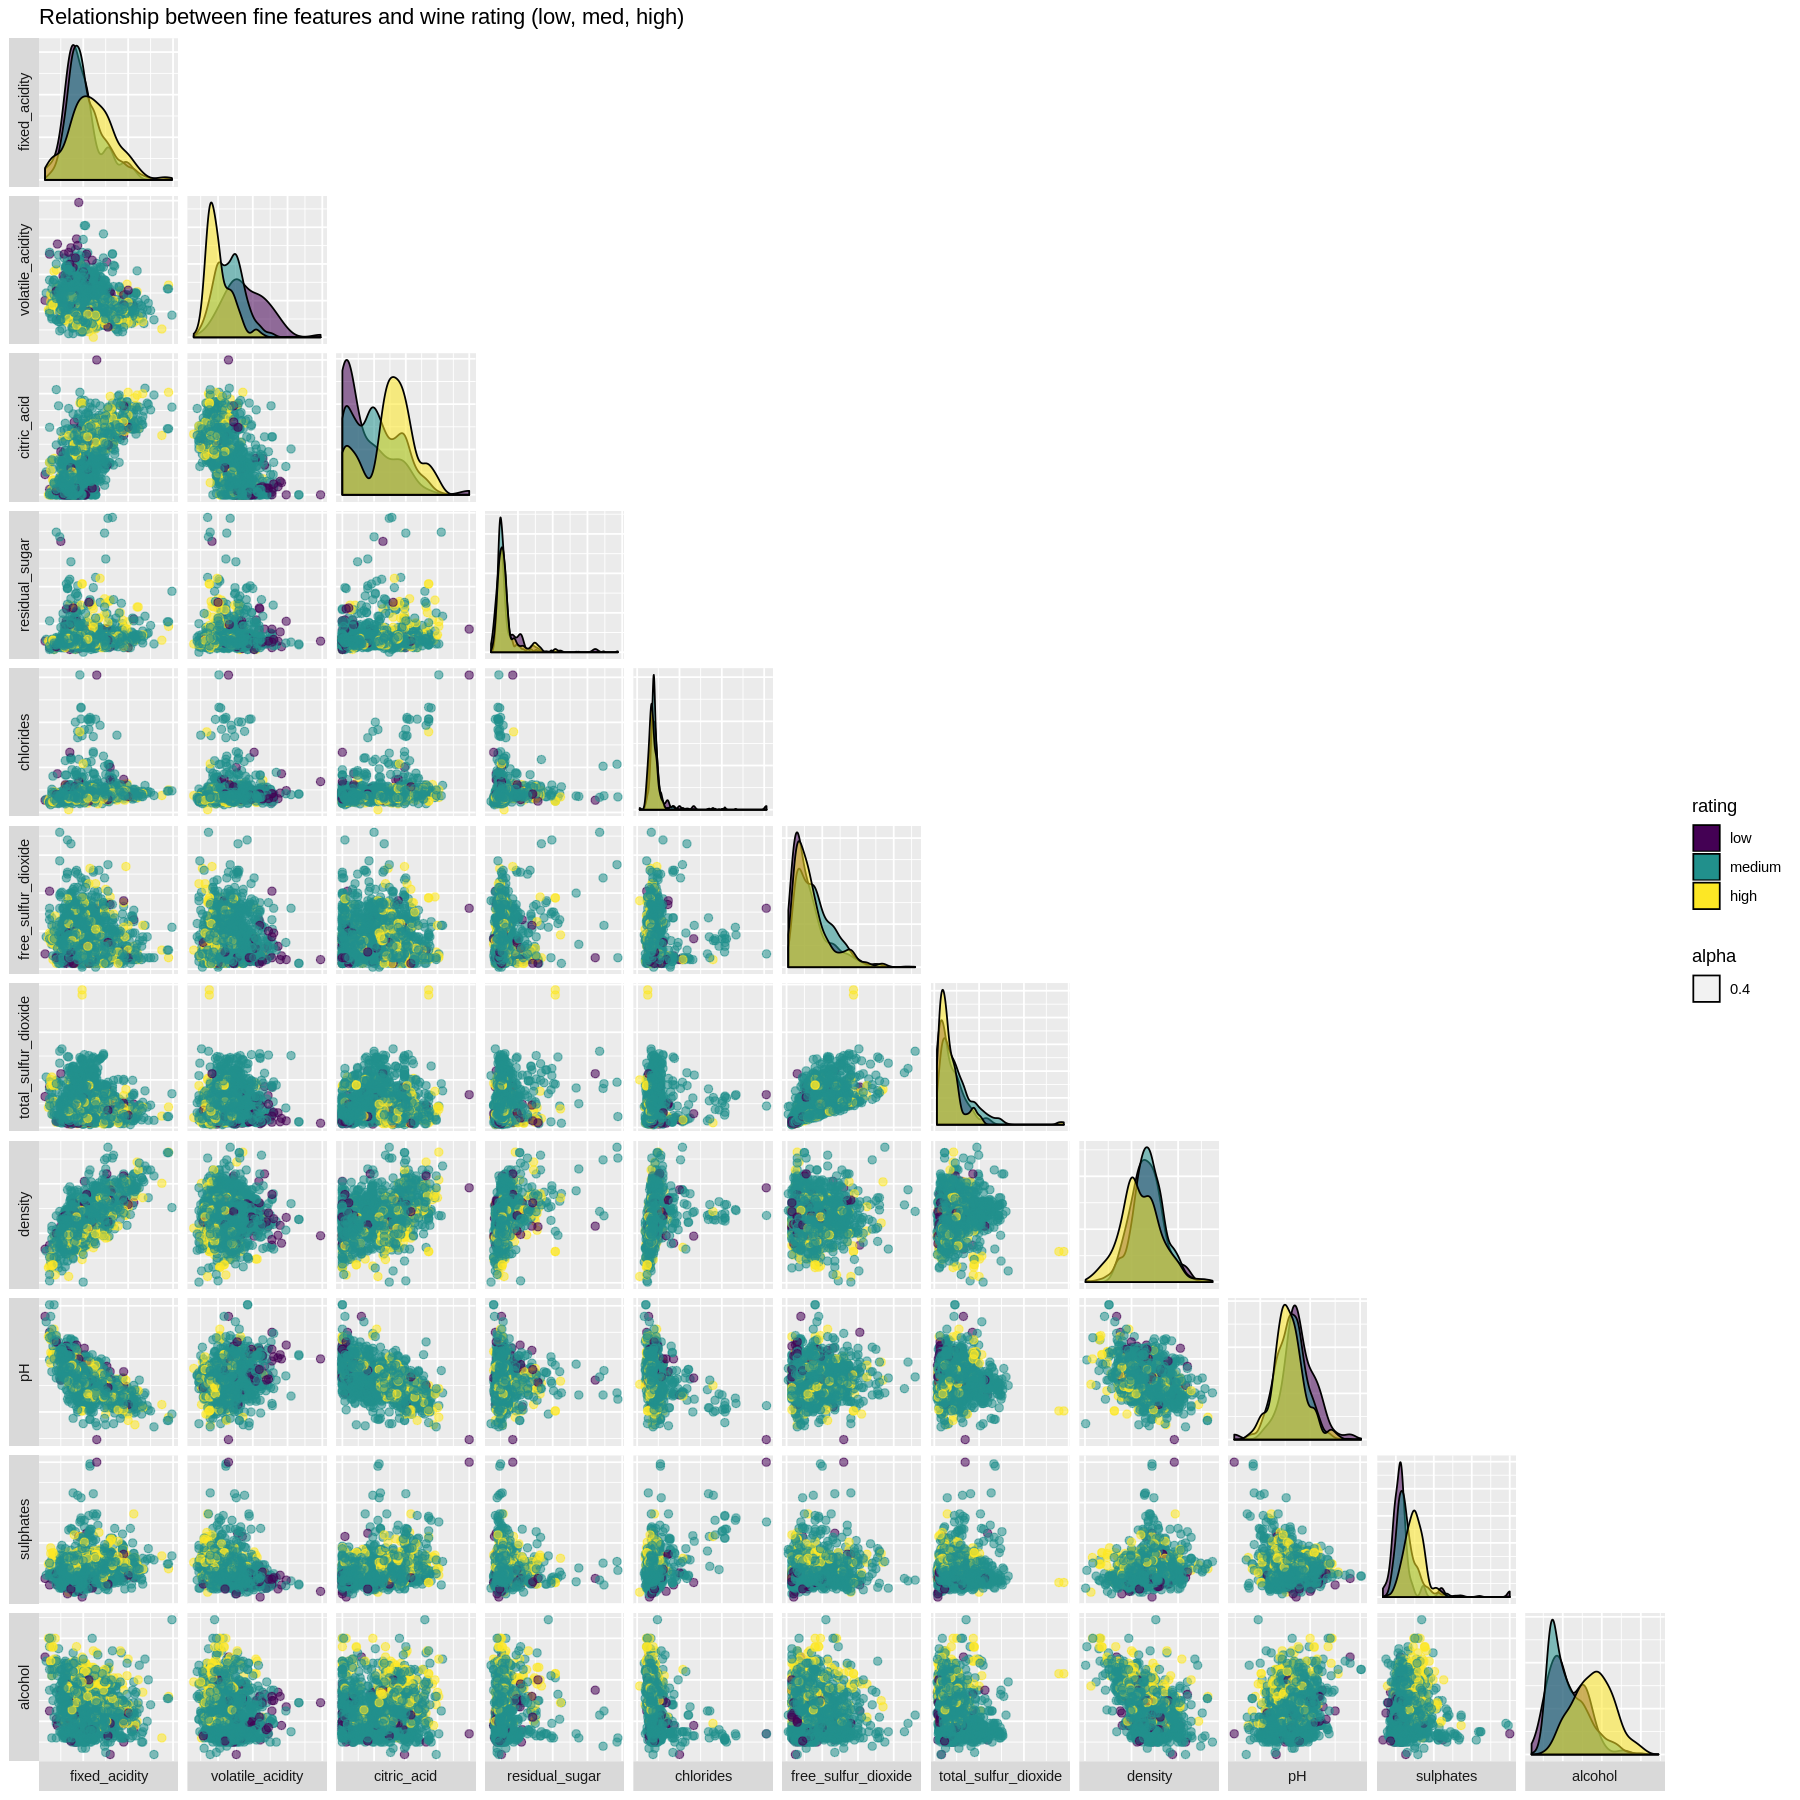

In [601]:
options(repr.plot.width = 15, repr.plot.height = 15)

wine %>% 
  ggpairs(aes(color = rating, 
              alpha=0.4),
              columns = 1:11,
              lower=list(continuous=wrap("points", size=2)),
              upper=list(continuous="blank"),
              axisLabels="none", switch="both",
              legend = c(1,1), 
              title = 'Relationship between fine features and wine rating (low, med, high)')

dev.copy(png,"pairplot1.png")
dev.off()

png 
  6

png 
  2

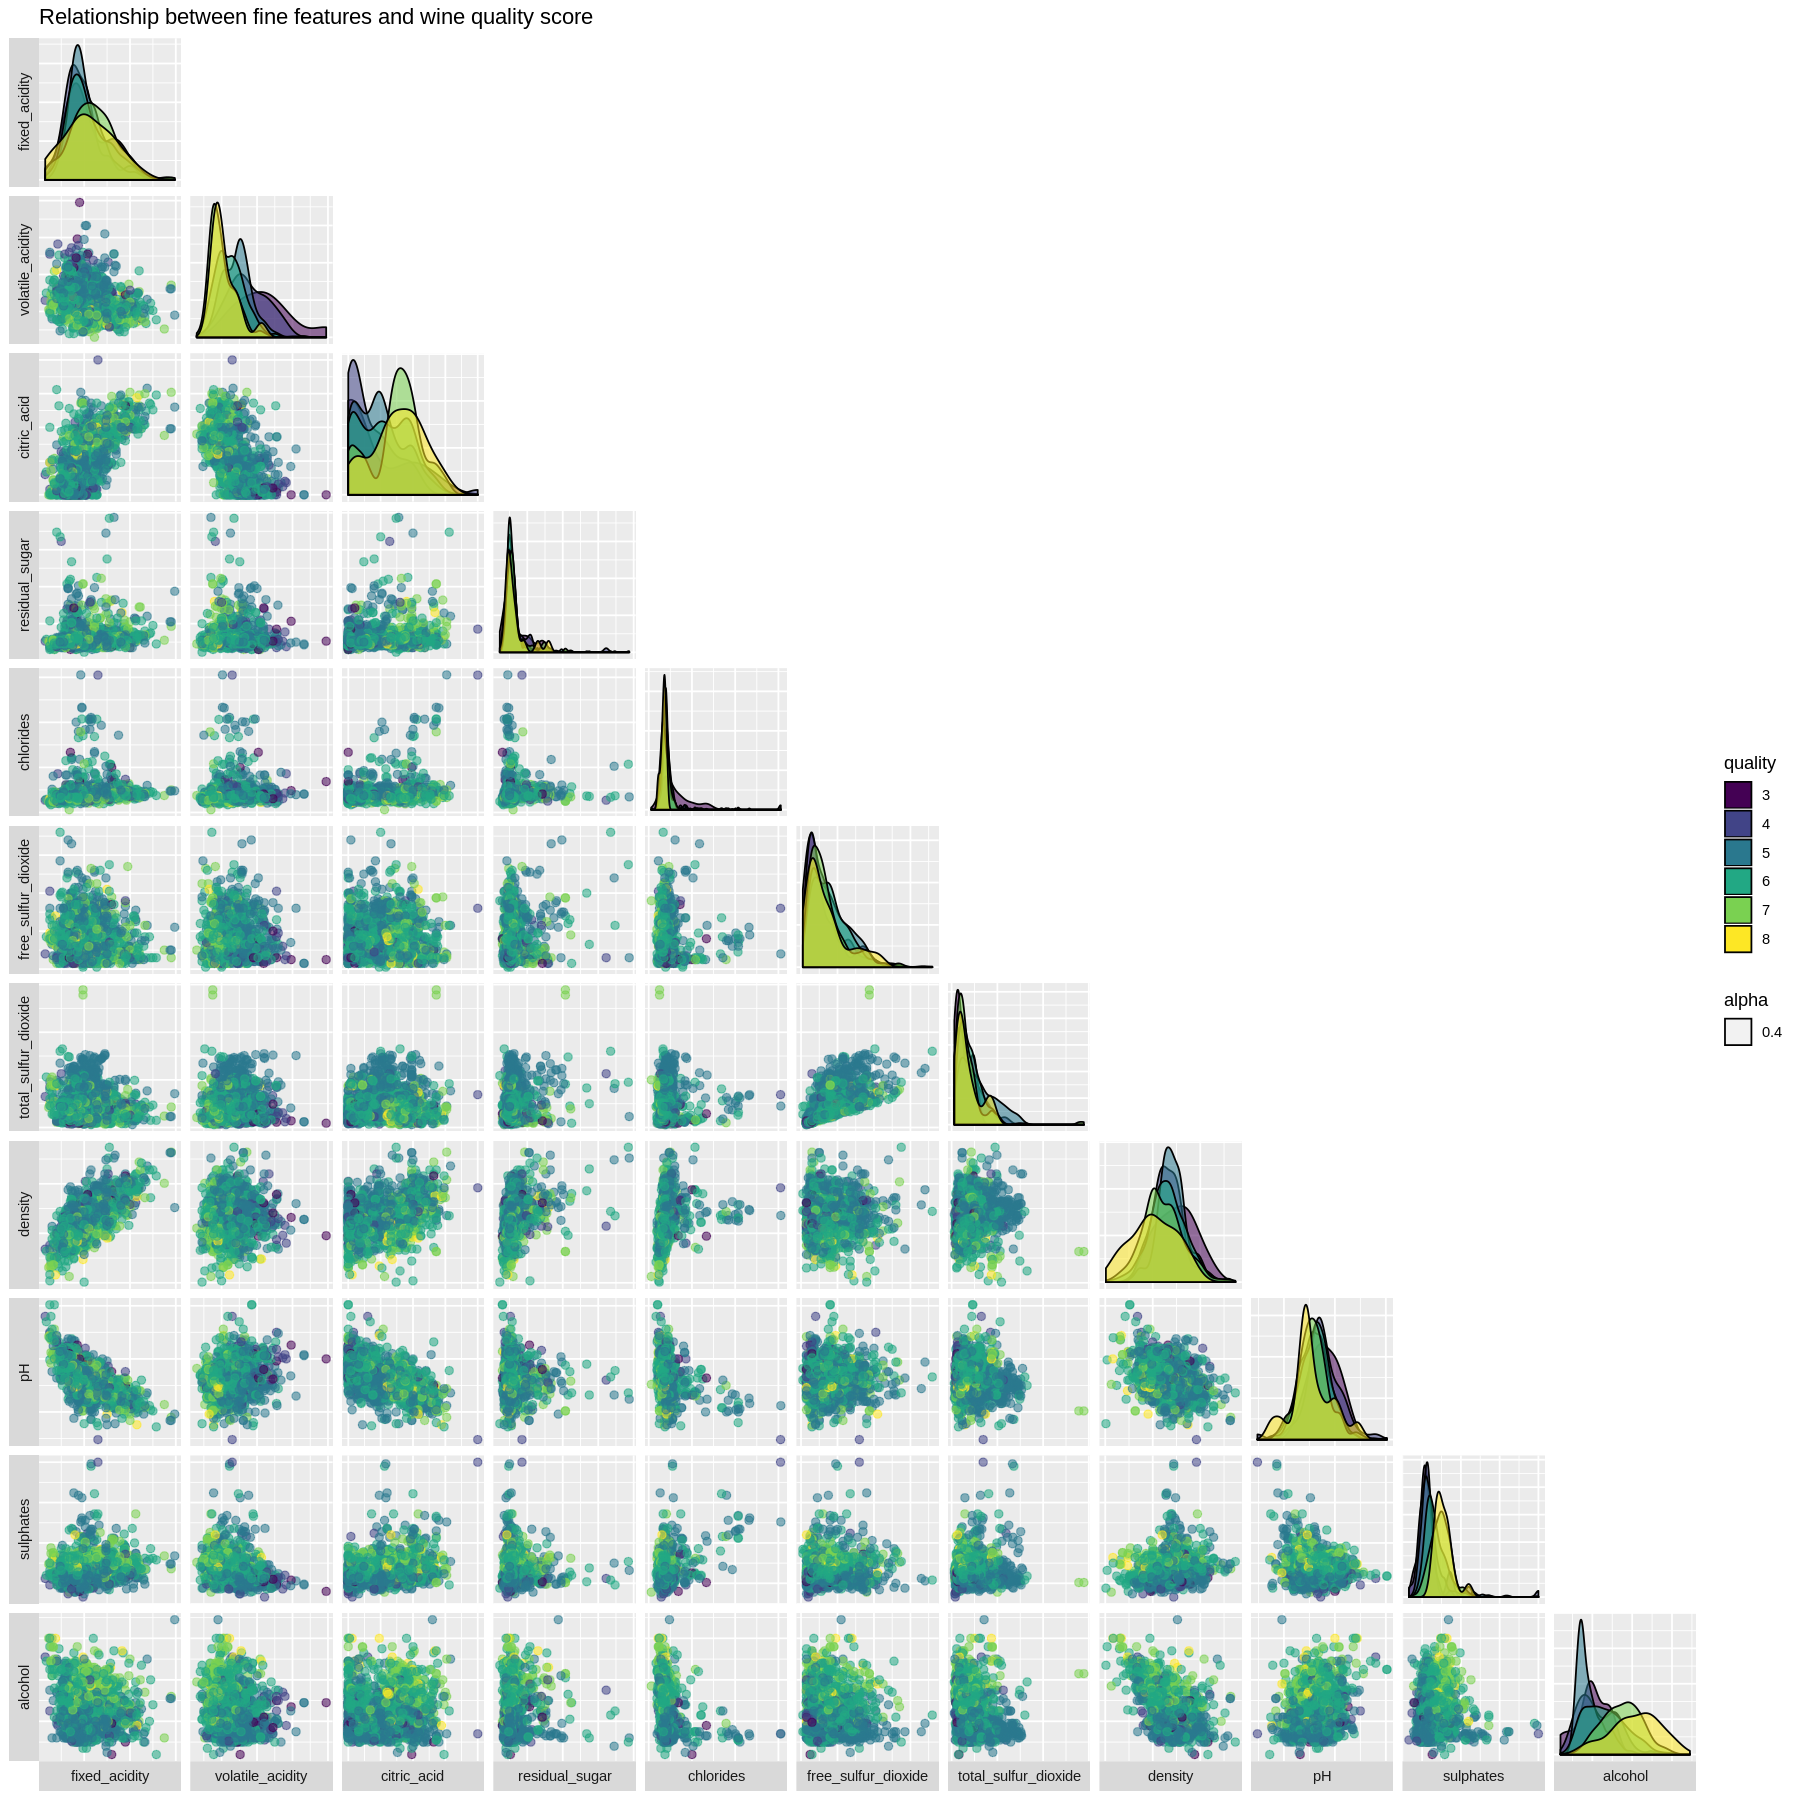

In [602]:
options(repr.plot.width = 15, repr.plot.height = 15)

wine %>% 
  ggpairs(aes(color = quality, 
              alpha=0.4),
              columns = 1:11,
              lower=list(continuous=wrap("points", size=2)),
              upper=list(continuous="blank"),
              axisLabels="none", switch="both",
              legend = c(1,1), 
              title = 'Relationship between wine features and wine quality score')


dev.copy(png,"pairplot2.png")
dev.off()

### We can see from these pairplots that alcohol content and also possibly citric acid content are higher in the higher quality wines. 
### Residual sugar, chlorides, free sulphur dioxide and total sulphur dioxide don't look to vary across the different quality ratings. We can look at the relationship between these individual features and wine quality more closely. 

png 
  6

png 
  2

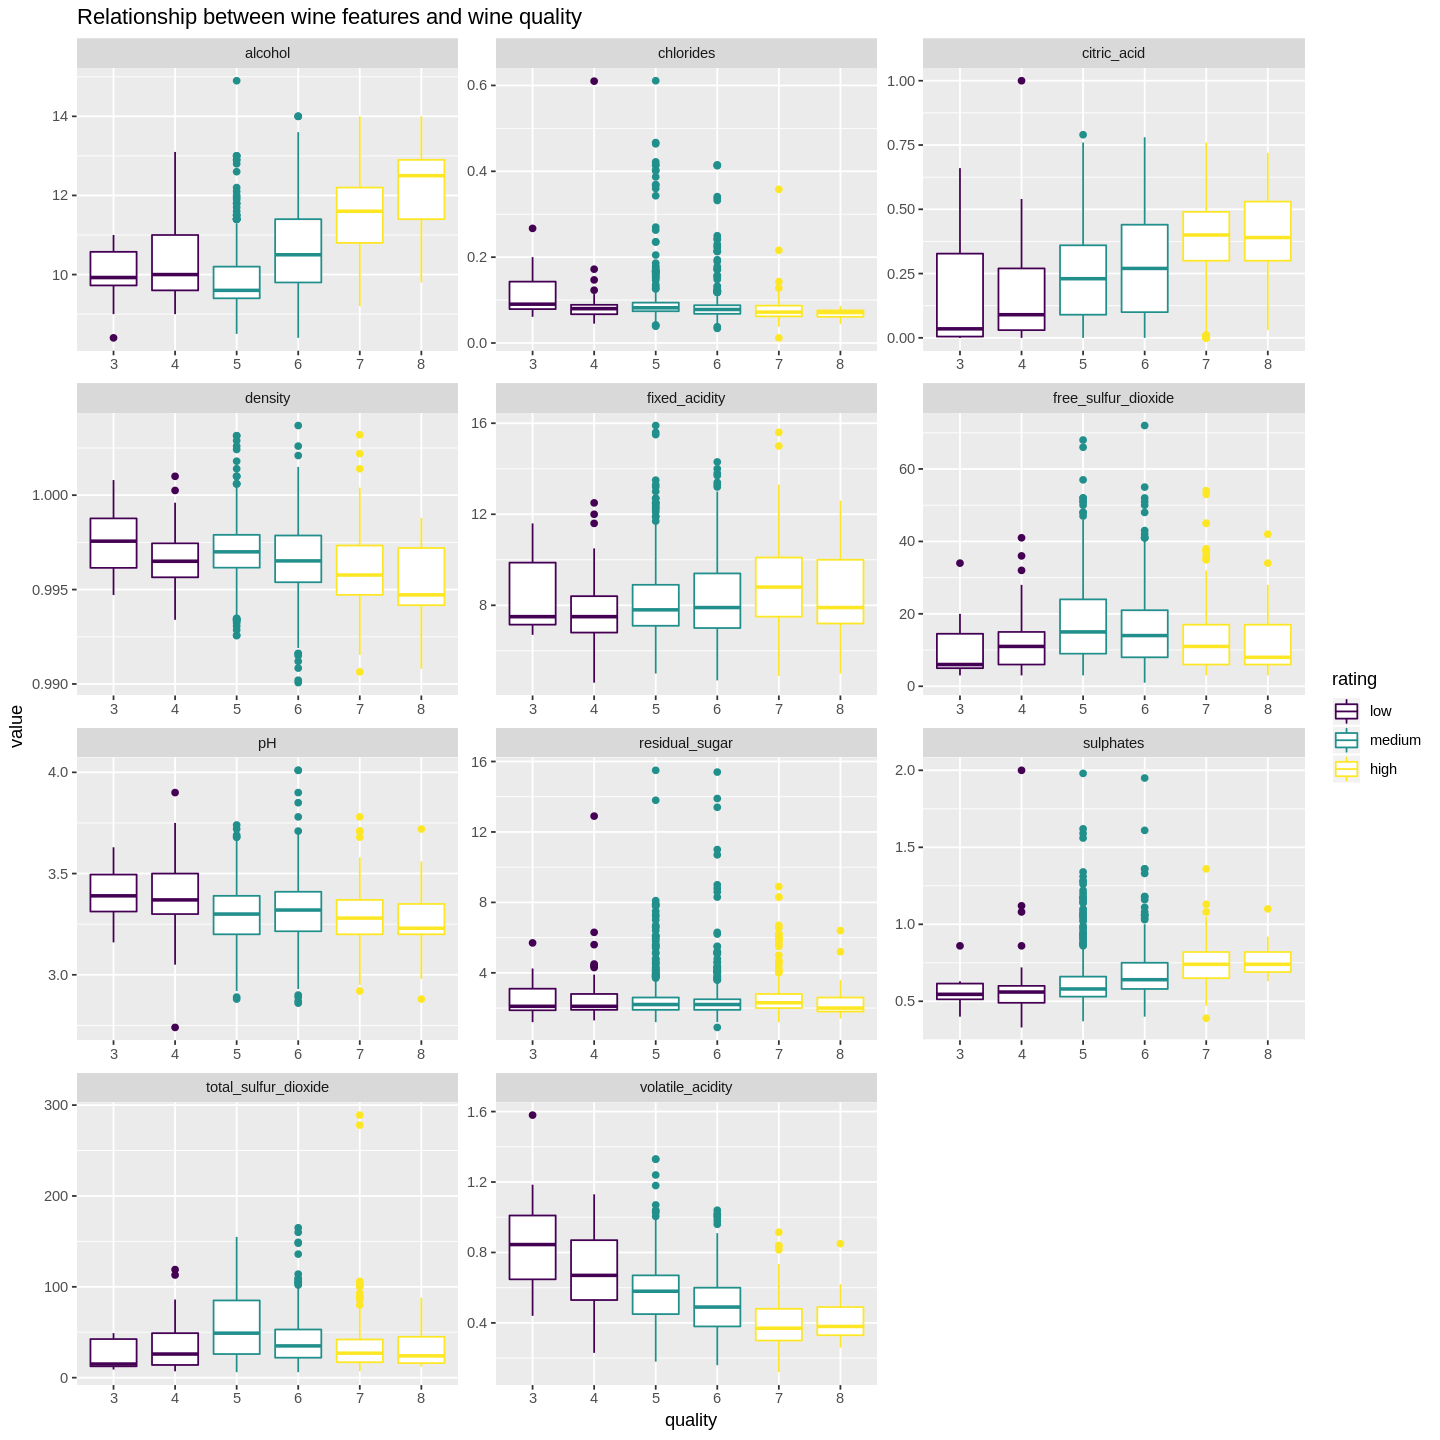

In [603]:
options(repr.plot.width = 12, repr.plot.height = 12)

plt <- wine %>% gather(-c(quality,rating), key = "var", value = "value") %>% 
  ggplot(aes(x = quality, y = value, color = rating, title = 'c')) +
    geom_boxplot() +
    facet_wrap(~ var, scales = "free", ncol = 3)+
    theme(legend.position="right")

plt + ggtitle('Relationship between wine features and wine quality')


dev.copy(png,"boxplot.png")
dev.off()

#### We appear to have some outliers in the dataset. Without better domain knowledge, and information about how the data was collected, it is not reasonable to remove outliers. We have a small dataset, so the outliers pose 2 main problems: They might be having a large effect (especially in underrepresented classes). But also removing them will further decrease the size of out dataset
#### That being said, there are a couple of rows that I am going to remove, the row where citric_acid == 1, as that row represents outliers in other features too. And the rows where total sulfur dioxide are almost 300, as they are alost an order of amgnitude larger than the other values. 


In [604]:

wine[ which(wine$total_sulfur_dioxide > 250),]
wine[ which(wine$citric_acid > 0.9),]

fixed_acidity volatile_acidity citric_acid residual_sugar chlorides
919 7.9           0.3              0.68        8.3            0.05     
921 7.9           0.3              0.68        8.3            0.05     
    free_sulfur_dioxide total_sulfur_dioxide density pH   sulphates alcohol
919 37.5                278                  0.99316 3.01 0.51      12.3   
921 37.5                289                  0.99316 3.01 0.51      12.3   
    quality rating
919 7       high  
921 7       high

fixed_acidity volatile_acidity citric_acid residual_sugar chlorides
136 9.2           0.52             1           3.4            0.61     
    free_sulfur_dioxide total_sulfur_dioxide density pH   sulphates alcohol
136 32                  69                   0.9996  2.74 2         9.4    
    quality rating
136 4       low

In [610]:
wine <- wine[-(c(136,919,921)),]

png 
  6

png 
  2

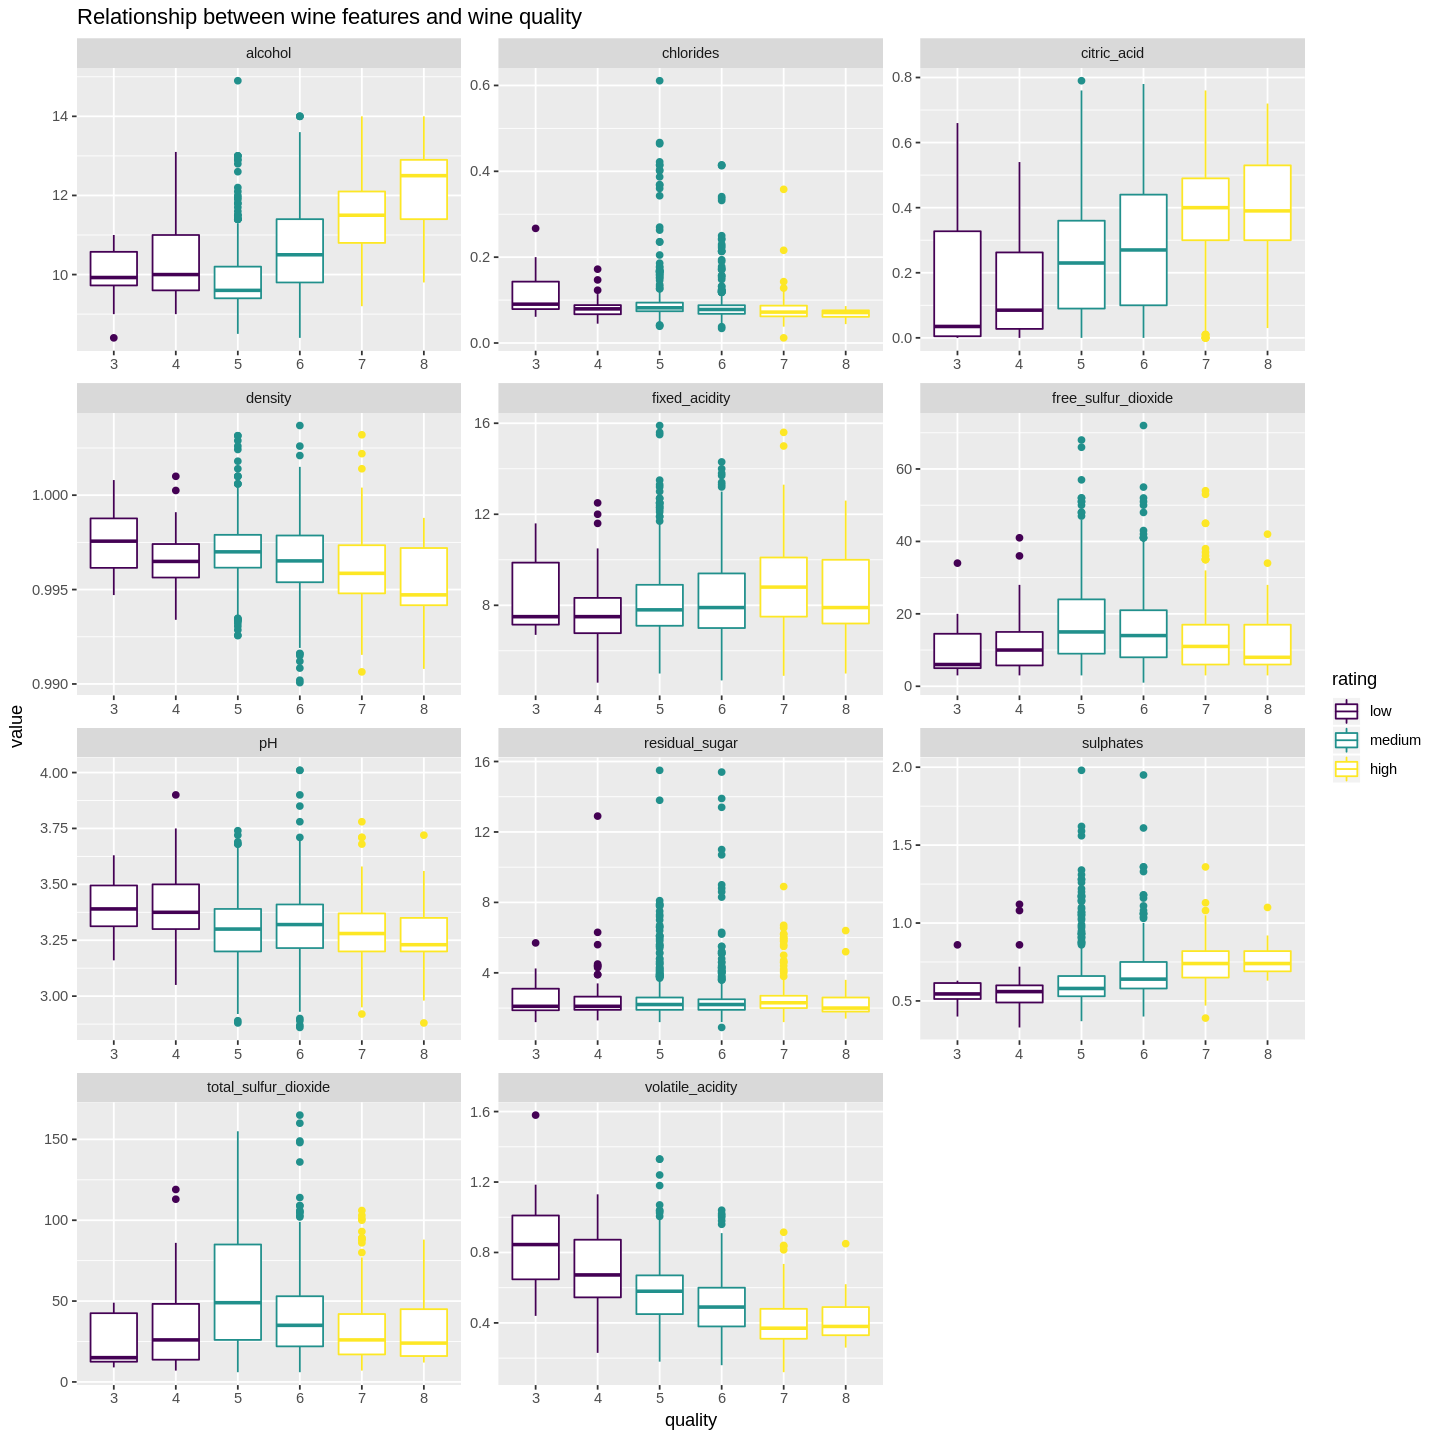

In [611]:
options(repr.plot.width = 12, repr.plot.height = 12)

plt <- wine %>% gather(-c(quality,rating), key = "var", value = "value") %>% 
  ggplot(aes(x = quality, y = value, color = rating, title = 'c')) +
    geom_boxplot() +
    facet_wrap(~ var, scales = "free", ncol = 3)+
    theme(legend.position="right")

plt + ggtitle('Relationship between wine features and wine quality')


dev.copy(png,"boxplot_severe_outliers_removed.png")
dev.off()


## ----

#### As we identified earlier, alcohol and citric acid seem to be higher in better quality wines. There is perhaps a trend for sulphates to be higher in better quality wines. Volatile acidity look to be decreased in higher quality wines and there is perhaps a slight trend for density and pH to be decreased in better quality wines. 
#### Residual sugar, chlorides, free sulphur dioxide and total sulphur dioxide remain unchanged across all wine ratings/quality.

## Building a model to predict wine quality
#### My first step will be to carry out linear discriminant analysis to see how well the wine categories separate. If they separate well then we can use a relatively simple model, if the clusters do not separate well then we many need to use a more complex model.  

In [612]:
r <- lda(formula = quality ~ ., 
         data = wine[-13])

r

Call:
lda(quality ~ ., data = wine[-13])

Prior probabilities of groups:
          3           4           5           6           7           8 
0.007374631 0.038348083 0.425516224 0.394542773 0.121681416 0.012536873 

Group means:
  fixed_acidity volatile_acidity citric_acid residual_sugar  chlorides
3      8.360000        0.8845000   0.1710000       2.635000 0.12250000
4      7.751923        0.6973077   0.1582692       2.680769 0.08069231
5      8.171231        0.5785962   0.2445234       2.509532 0.09397054
6      8.337383        0.4960841   0.2793645       2.457290 0.08507477
7      8.870303        0.4049091   0.3681212       2.649091 0.07715758
8      8.441176        0.4276471   0.3829412       2.576471 0.06835294
  free_sulfur_dioxide total_sulfur_dioxide   density       pH sulphates
3            11.00000             24.90000 0.9974640 3.398000 0.5700000
4            11.88462             35.61538 0.9964837 3.393846 0.5694231
5            17.16118             57.40641 0.9970823 3

In [613]:
plda <- predict(object = r,
                newdata = wine)

In [614]:
head(plda$x)

LD1         LD2        LD3         LD4         LD5       
1 -1.43475650 -0.7489009  1.29842492 -0.71399605 -0.2273239
2 -1.27765505 -0.2506504 -0.55405043  0.54678357  1.3665533
3 -1.09720875 -0.0888788 -0.23352283 -0.06473493  0.7808700
4 -0.03477226  0.8592988 -0.08408392  0.10826462 -1.9635403
5 -1.39898596 -0.4306411  1.42114976 -0.75450546 -0.2802119
6 -1.48065953  0.3706579  0.16652315 -0.95624211 -0.2749944

In [615]:
wine_lda = data.frame(quality = wine[,"quality"],
                     lda = plda$x)

head(wine_lda)

quality lda.LD1     lda.LD2    lda.LD3     lda.LD4     lda.LD5   
1 5       -1.43475650 -0.7489009  1.29842492 -0.71399605 -0.2273239
2 5       -1.27765505 -0.2506504 -0.55405043  0.54678357  1.3665533
3 5       -1.09720875 -0.0888788 -0.23352283 -0.06473493  0.7808700
4 6       -0.03477226  0.8592988 -0.08408392  0.10826462 -1.9635403
5 5       -1.39898596 -0.4306411  1.42114976 -0.75450546 -0.2802119
6 5       -1.48065953  0.3706579  0.16652315 -0.95624211 -0.2749944

In [616]:
m <- list(l = 2, r = 0, b = 10, t = 50, pad = 6)

plot_ly(x=wine_lda$lda.LD1, y=wine_lda$lda.LD2, z=wine_lda$lda.LD3, type="scatter3d", mode="markers", color=wine_lda$quality, opacity = 0.7, width = 700, height = 700) %>% 

      layout(title = "LDA on Wine Quality", 
             margin = m,
             annotations=list(yref='paper',xref="paper",y=1.05,x=1.1, text="quality",showarrow=FALSE),
             scene = list(xaxis = list(title = 'LD1'),
                          yaxis = list(title = 'LD2'),
                          zaxis = list(title = 'LD3')))


dev.copy(png,"LDA.png")
dev.off()

HTML widgets cannot be represented in plain text (need html)

png 
  6

png 
  2

## Model Selection:
#### As well as the afore mentioned reasons (mulitcollinearity, potential outliers), the lack of clear separation between between the wine qualities in the LDA analysis means we will likely need to use more complex models to predict wine quality. My best options are probably a random forest or a boosted tree (xgboost). Random Forest typically works well "out of the box" with less hyperparameter tuning needed. Random forests are also typically harder to overfit than boosted trees. Outliers can increase our chance of overfitting, therefore I will build a random forest model to predict wine quality. 

## Random Forest

#### First we need to split the data into a training dataset and a test dataset. We'll use cross-validation to hyperparameter tune using the training dataset, and predict on the test dataset as the final test. 

In [617]:
# drop the rating feature that I created

wineModel <- wine[-13]
head(wineModel)

fixed_acidity volatile_acidity citric_acid residual_sugar chlorides
1  7.4          0.70             0.00        1.9            0.076    
2  7.8          0.88             0.00        2.6            0.098    
3  7.8          0.76             0.04        2.3            0.092    
4 11.2          0.28             0.56        1.9            0.075    
5  7.4          0.66             0.00        1.8            0.075    
6  7.9          0.60             0.06        1.6            0.069    
  free_sulfur_dioxide total_sulfur_dioxide density pH   sulphates alcohol
1 11                  34                   0.9978  3.51 0.56      9.4    
2 25                  67                   0.9968  3.20 0.68      9.8    
3 15                  54                   0.9970  3.26 0.65      9.8    
4 17                  60                   0.9980  3.16 0.58      9.8    
5 13                  40                   0.9978  3.51 0.56      9.4    
6 15                  59                   0.9964  3.30 0.46      9.4    
  quality
1 5      
2 5      
3 5      
4 6      
5 5      
6 5

In [618]:
set.seed(42)

#need to rename factors so that they can be valid R variable names (this is require for the caret function I will use to split the data)
levels(wineModel$quality) <- c("three", "four", "five", "six", "seven", "eight")


# split into a train and test dataset, normally I would use a 80/20 or 70/30 split, but as we have a pretty small dataset I'm going to use a 85/15 split
trainIndex <- createDataPartition(wineModel$quality, p = 0.85, 
                                  list = FALSE)

wineTrain <- wineModel[trainIndex,]
wineTest <- wineModel[-trainIndex,]

In [619]:
cat("Check the label/class distribution in the training dataset:")
table(wineTrain$quality)
cat("\n\nCheck the label/class distribution in the test dataset:")
table(wineTest$quality)
cat("\n\nRatio of labels/classes between train and test datasets:")
table(wineTest$quality)/table(wineTrain$quality)

Check the label/class distribution in the training dataset:


three  four  five   six seven eight 
    9    45   491   455   141    15 



Check the label/class distribution in the test dataset:


three  four  five   six seven eight 
    1     7    86    80    24     2 



Ratio of labels/classes between train and test datasets:


    three      four      five       six     seven     eight 
0.1111111 0.1555556 0.1751527 0.1758242 0.1702128 0.1333333 

## Custom RF for hyperparameter tuning
#### The caret package only allows tuning of the mtry hyperparameter for it's random forest model. I would also like to tune the number of trees, so I need to build a custom random forest

In [620]:
# Building a custom random forest model

customRF <- list(type = "Classification", library = "randomForest", loop = NULL)
customRF$parameters <- data.frame(parameter = c("mtry", "ntree"), class = rep("numeric", 2), label = c("mtry", "ntree"))
customRF$grid <- function(x, y, len = NULL, search = "grid") {}
customRF$fit <- function(x, y, wts, param, lev, last, weights, classProbs, ...) {
  randomForest(x, y, mtry = param$mtry, ntree=param$ntree, ...)
}
customRF$predict <- function(modelFit, newdata, preProc = NULL, submodels = NULL)
   predict(modelFit, newdata)
customRF$prob <- function(modelFit, newdata, preProc = NULL, submodels = NULL)
   predict(modelFit, newdata, type = "prob")
customRF$sort <- function(x) x[order(x[,1]),]
customRF$levels <- function(x) x$classes


In [621]:
# train model
control <- trainControl(method="repeatedcv", number=8, repeats=3)
tunegrid <- expand.grid(.mtry=c(1:7), .ntree=c(500, 1000, 2000))
set.seed(0)
custom <- train(quality~., data=wineTrain, method=customRF, metric="Accuracy", tuneGrid=tunegrid, trControl=control)


png 
  6

png 
  2

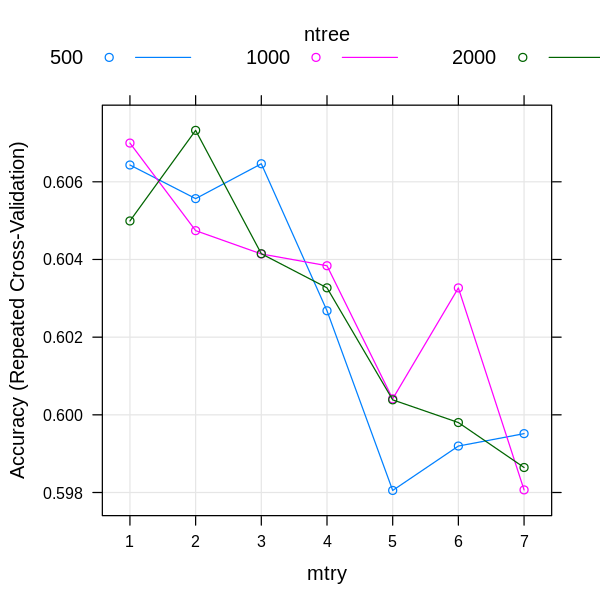

In [622]:
options(repr.plot.width = 5, repr.plot.height = 5)
plot(custom)

dev.copy(png,"Tuning.png")
dev.off()

## Train final model and test on the heldout test dataset (15% of the data)
### From our cross validation and hyperparameter tuning it looks like a an ntree value of 2000 and a mtry value of 2 is optimal for this dataset. 


In [623]:
set.seed(1)

rf_model <- randomForest(quality~., data = wineTrain, mtry = 2, ntree = 2000)

rf_result <- predict(rf_model, newdata = wineTest[-12])

caret::confusionMatrix(rf_result, wineTest$quality, mode = "prec_recall")

Confusion Matrix and Statistics

          Reference
Prediction three four five six seven eight
     three     0    0    0   0     0     0
     four      0    0    0   0     0     0
     five      1    5   68  21     0     0
     six       0    1   18  56    18     1
     seven     0    1    0   3     6     1
     eight     0    0    0   0     0     0

Overall Statistics
                                          
               Accuracy : 0.65            
                 95% CI : (0.5795, 0.7159)
    No Information Rate : 0.43            
    P-Value [Acc > NIR] : 3.09e-10        
                                          
                  Kappa : 0.4178          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: three Class: four Class: five Class: six
Precision                      NA          NA      0.7158     0.5957
Recall                      0.000       0.000      0.7907     0.7000
F1                             NA          NA      0

In [664]:
round(importance(rf_model), 2)


MeanDecreaseGini
fixed_acidity         57.97          
volatile_acidity      75.41          
citric_acid           56.82          
residual_sugar        54.34          
chlorides             63.62          
free_sulfur_dioxide   52.81          
total_sulfur_dioxide  75.57          
density               70.25          
pH                    57.71          
sulphates             81.64          
alcohol              101.78

## Looking deeper at feature importance

In [641]:
ozone.rfP <- rfPermute(quality ~ ., data = wineTrain, ntree = 2000, mtry = 2, importance = TRUE)

png 
  6

png 
  2

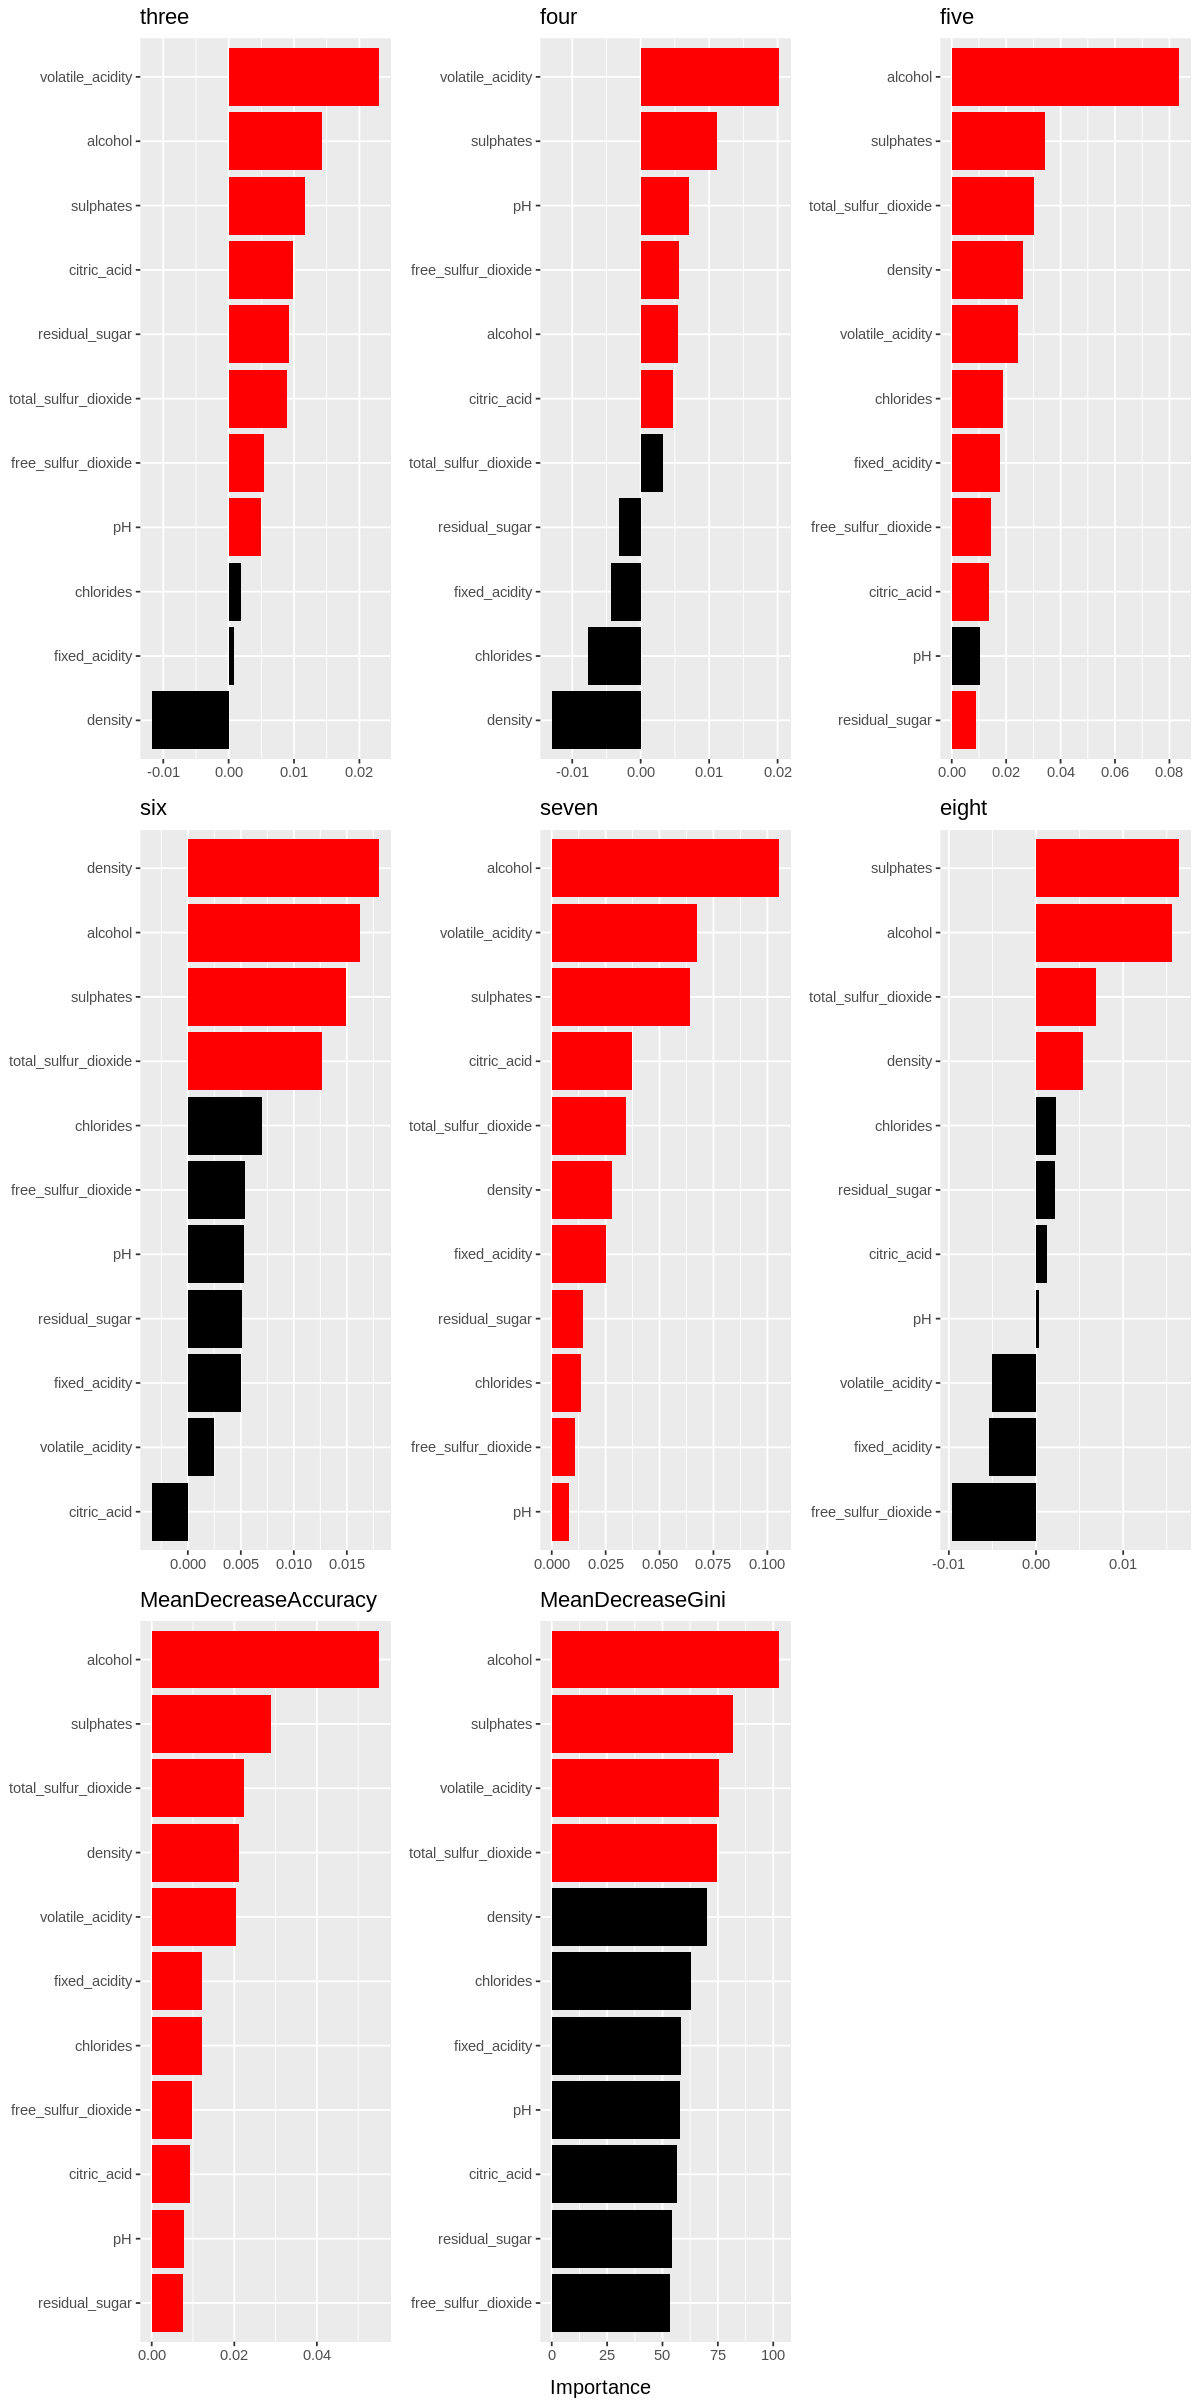

png 
  6

png 
  2

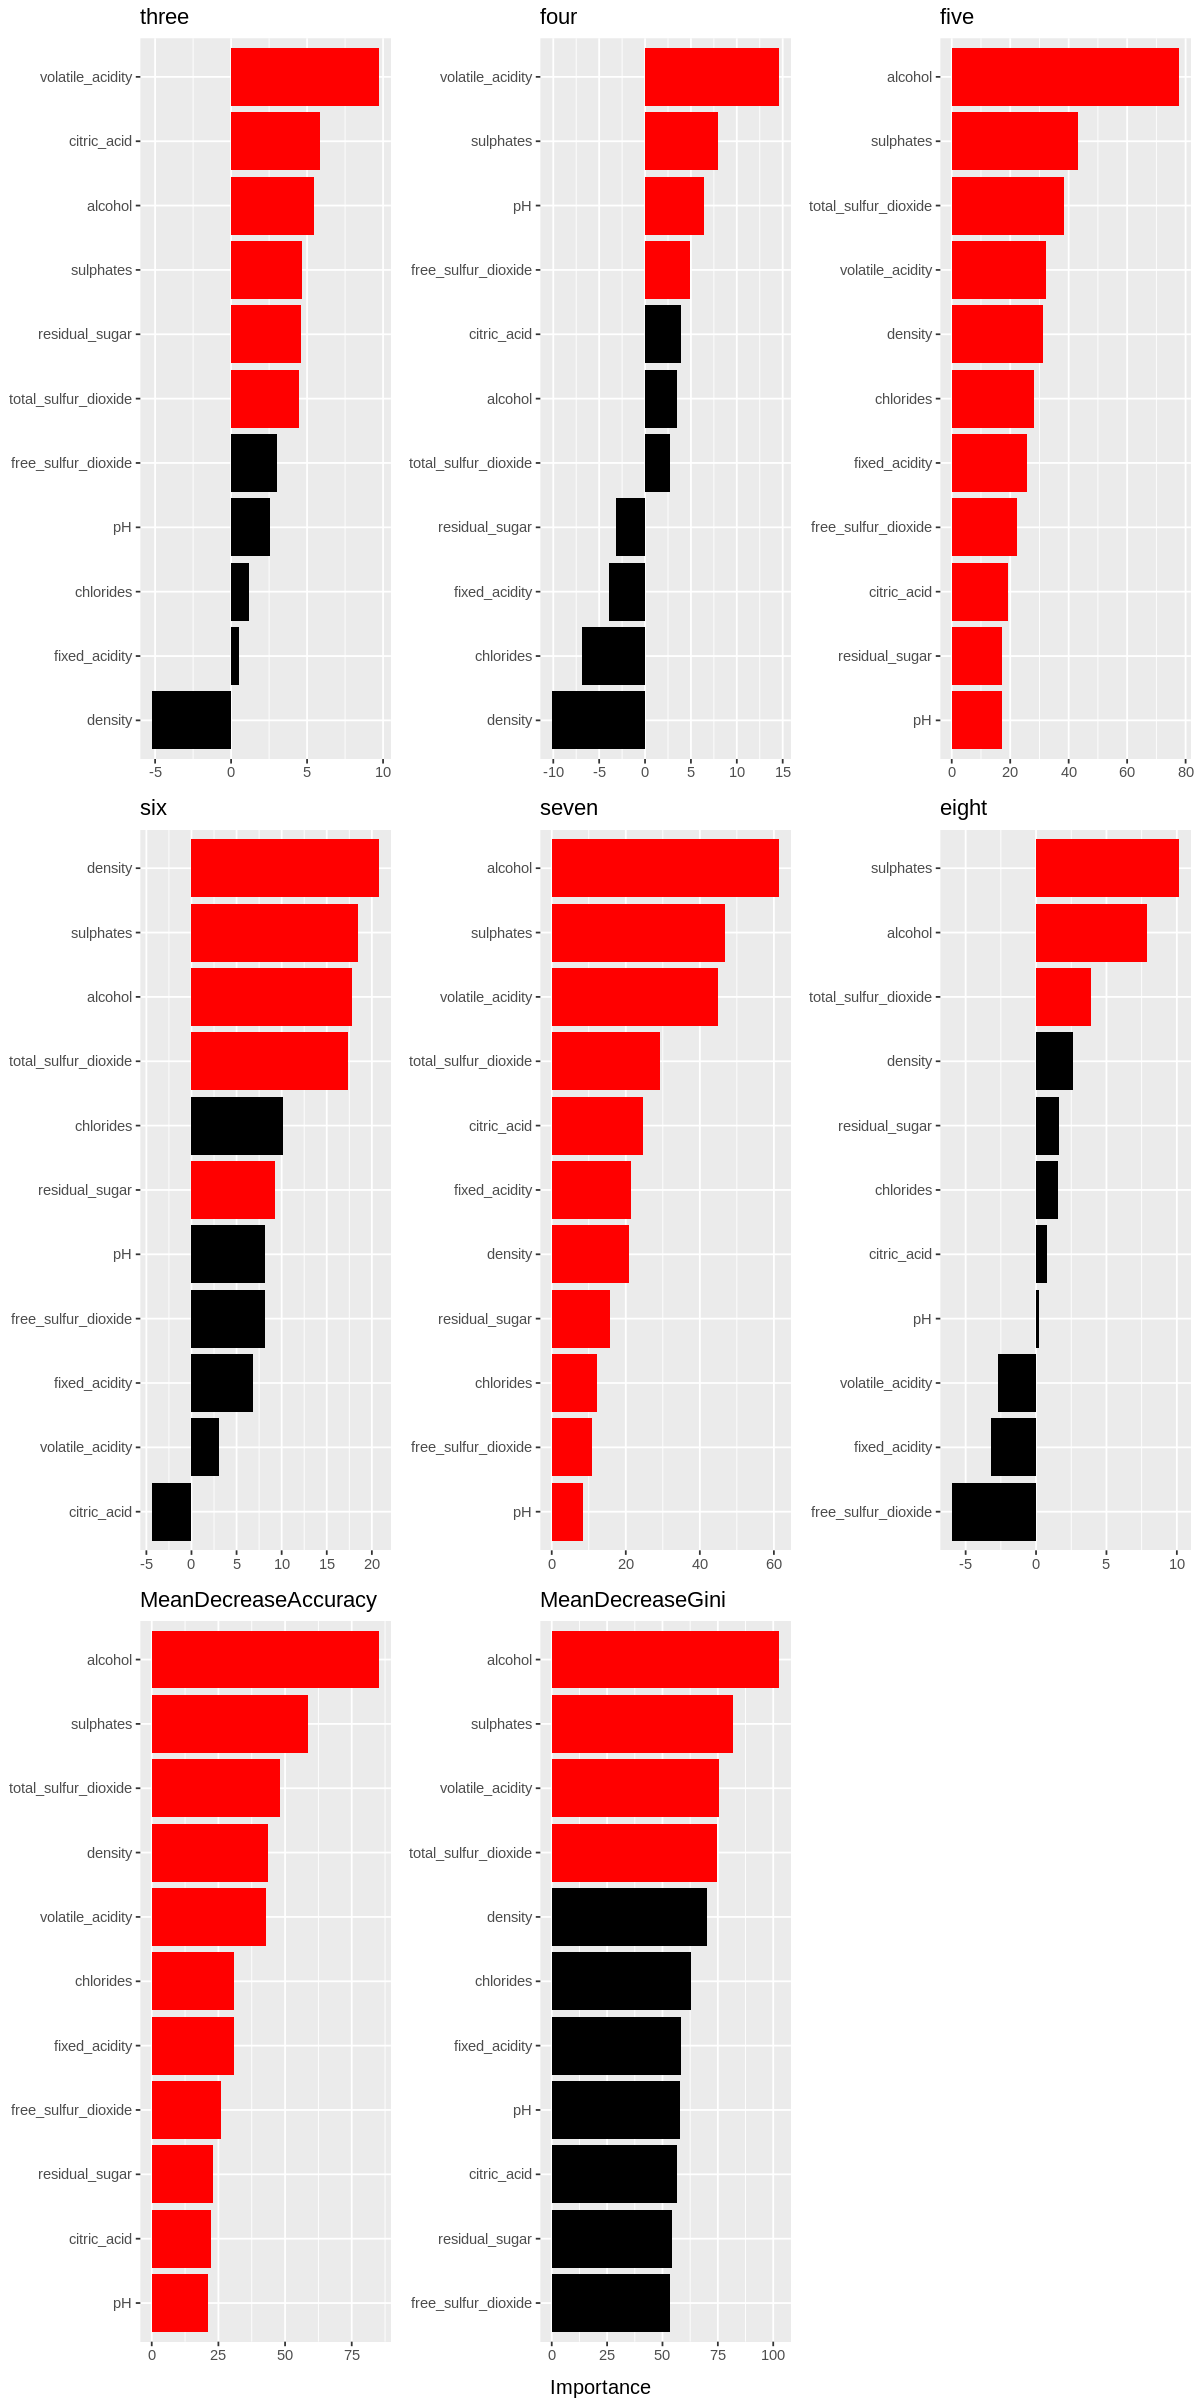

In [643]:
# Plot the unscaled importance distributions and highlight significant predictors
options(repr.plot.width = 10, repr.plot.height = 20)

plot(rp.importance(ozone.rfP, scale = FALSE))

dev.copy(png,"Importances_permute.png")
dev.off()
  
# ... and the scaled measures
plot(rp.importance(ozone.rfP, scale = TRUE))

dev.copy(png,"Importances_permute_scaled.png")
dev.off()

## Statistical analysis of important features:
#### First we need to check for normality, both by test and by visually inspecting


Normality test for alcohol feature, where rating is low


	Shapiro-Wilk normality test

data:  df$alcohol
W = 0.96031, p-value = 0.04295


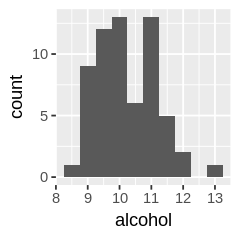

In [646]:
options(repr.plot.width = 2, repr.plot.height = 2)
#normality tests 

cat('Normality test for alcohol feature, where rating is low')
df <- wine[ which(wine$rating == 'low'),]
shapiro.test(df$alcohol)

ggplot(df, aes(x=alcohol)) + 
  geom_histogram(binwidth=0.5)



Normality test for alcohol feature, where rating is medium


	Shapiro-Wilk normality test

data:  df$alcohol
W = 0.90783, p-value < 2.2e-16


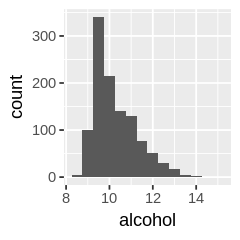

In [647]:
cat('\n\nNormality test for alcohol feature, where rating is medium')
df <- wine[ which(wine$rating == 'medium'),]
shapiro.test(df$alcohol)

ggplot(df, aes(x=alcohol)) + 
  geom_histogram(binwidth=0.5)



Normality test for alcohol feature, where rating is high


	Shapiro-Wilk normality test

data:  df$alcohol
W = 0.99074, p-value = 0.29


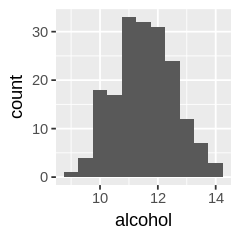

In [648]:
cat('\n\nNormality test for alcohol feature, where rating is high')
df <- wine[ which(wine$rating == 'high'),]
shapiro.test(df$alcohol)

ggplot(df, aes(x=alcohol)) + 
  geom_histogram(binwidth=0.5)



Normality test for sulphates feature, where rating is low


	Shapiro-Wilk normality test

data:  df$sulphates
W = 0.79817, p-value = 8.5e-08


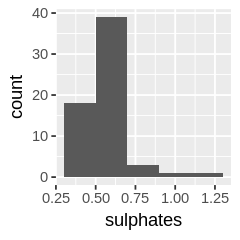

In [649]:
cat('\n\nNormality test for sulphates feature, where rating is low')
df <- wine[ which(wine$rating == 'low'),]
shapiro.test(df$sulphates)

ggplot(df, aes(x=sulphates)) + 
  geom_histogram(binwidth=0.2)



Normality test for sulphates feature, where rating is medium


	Shapiro-Wilk normality test

data:  df$sulphates
W = 0.80287, p-value < 2.2e-16


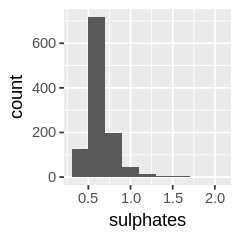

In [650]:
cat('\n\nNormality test for sulphates feature, where rating is medium')
df <- wine[ which(wine$rating == 'medium'),]
shapiro.test(df$sulphates)

ggplot(df, aes(x=sulphates)) + 
  geom_histogram(binwidth=0.2)



Normality test for sulphates feature, where rating is high


	Shapiro-Wilk normality test

data:  df$sulphates
W = 0.96657, p-value = 0.00024


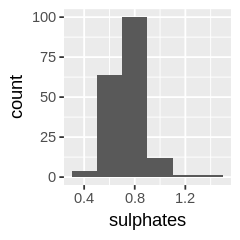

In [651]:
cat('\n\nNormality test for sulphates feature, where rating is high')
df <- wine[ which(wine$rating == 'high'),]
shapiro.test(df$sulphates)

ggplot(df, aes(x=sulphates)) + 
  geom_histogram(binwidth=0.2)



Normality test for volatile_acidity feature, where rating is low


	Shapiro-Wilk normality test

data:  df$volatile_acidity
W = 0.9723, p-value = 0.1735


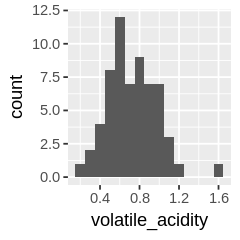

In [660]:
cat('\n\nNormality test for volatile_acidity feature, where rating is low')
df <- wine[ which(wine$rating == 'low'),]
shapiro.test(df$volatile_acidity)

ggplot(df, aes(x=volatile_acidity)) + 
  geom_histogram(binwidth=0.1)



Normality test for volatile_acidity feature, where rating is medium


	Shapiro-Wilk normality test

data:  df$volatile_acidity
W = 0.98187, p-value = 1.486e-10


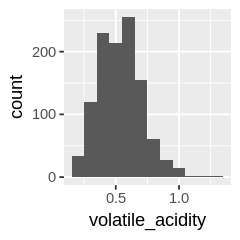

In [659]:
cat('\n\nNormality test for volatile_acidity feature, where rating is medium')
df <- wine[ which(wine$rating == 'medium'),]
shapiro.test(df$volatile_acidity)

ggplot(df, aes(x=volatile_acidity)) + 
  geom_histogram(binwidth=0.1)



Normality test for volatile_acidity feature, where rating is high


	Shapiro-Wilk normality test

data:  df$volatile_acidity
W = 0.92038, p-value = 2.137e-08


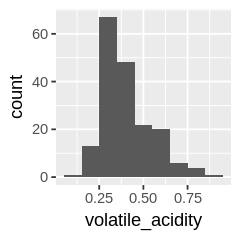

In [661]:
cat('\n\nNormality test for volatile_acidity feature, where rating is high')
df <- wine[ which(wine$rating == 'high'),]
shapiro.test(df$volatile_acidity)

ggplot(df, aes(x=volatile_acidity)) + 
  geom_histogram(binwidth=0.1)



Normality test for total sulfur dioxide feature, where rating is low


	Shapiro-Wilk normality test

data:  df$total_sulfur_dioxide
W = 0.84947, p-value = 2.152e-06


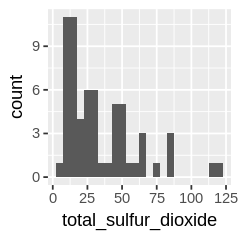

In [669]:
cat('\n\nNormality test for total sulfur dioxide feature, where rating is low')
df <- wine[ which(wine$rating == 'low'),]
shapiro.test(df$total_sulfur_dioxide)

ggplot(df, aes(x=total_sulfur_dioxide)) + 
  geom_histogram(binwidth=5)



Normality test for total sulfur dioxide feature, where rating is medium


	Shapiro-Wilk normality test

data:  df$total_sulfur_dioxide
W = 0.90154, p-value < 2.2e-16


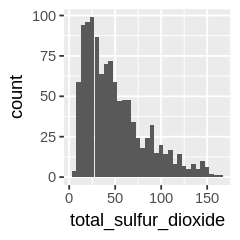

In [670]:
cat('\n\nNormality test for total sulfur dioxide feature, where rating is medium')
df <- wine[ which(wine$rating == 'medium'),]
shapiro.test(df$total_sulfur_dioxide)

ggplot(df, aes(x=total_sulfur_dioxide)) + 
  geom_histogram(binwidth=5)



Normality test for total sulfur dioxide feature, where rating is high


	Shapiro-Wilk normality test

data:  df$total_sulfur_dioxide
W = 0.84886, p-value = 1.868e-12


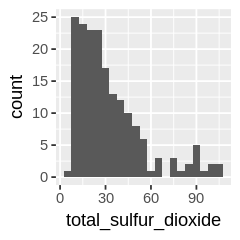

In [668]:
cat('\n\nNormality test for total sulfur dioxide feature, where rating is high')
df <- wine[ which(wine$rating == 'high'),]
shapiro.test(df$total_sulfur_dioxide)

ggplot(df, aes(x=total_sulfur_dioxide)) + 
  geom_histogram(binwidth=5)

In [671]:
cat("Significance test for differences in alcohol content across low, medium, and high rating")
kruskal.test(alcohol ~ rating, data = wine)

cat("\n\nSignificance test for differences in sulphate content across low, medium, and high rating")
kruskal.test(sulphates ~ rating, data = wine)

cat("\n\nSignificance test for differences in volatile acidity across low, medium, and high rating")
kruskal.test(volatile_acidity ~ rating, data = wine)

cat("\n\nSignificance test for differences in total sulfur dioxide acidity across low, medium, and high rating")
kruskal.test(total_sulfur_dioxide ~ rating, data = wine)

Significance test for differences in alcohol content across low, medium, and high rating


	Kruskal-Wallis rank sum test

data:  alcohol by rating
Kruskal-Wallis chi-squared = 197.37, df = 2, p-value < 2.2e-16




Significance test for differences in sulphate content across low, medium, and high rating


	Kruskal-Wallis rank sum test

data:  sulphates by rating
Kruskal-Wallis chi-squared = 140.51, df = 2, p-value < 2.2e-16




Significance test for differences in volatile acidity across low, medium, and high rating


	Kruskal-Wallis rank sum test

data:  volatile_acidity by rating
Kruskal-Wallis chi-squared = 145.54, df = 2, p-value < 2.2e-16




Significance test for differences in total sulfur dioxide acidity across low, medium, and high rating


	Kruskal-Wallis rank sum test

data:  total_sulfur_dioxide by rating
Kruskal-Wallis chi-squared = 62.132, df = 2, p-value = 3.223e-14


### There is a significant difference in the levels of these 4 wine feature/measures across the low, medium, and high ratings

png 
  6

png 
  2

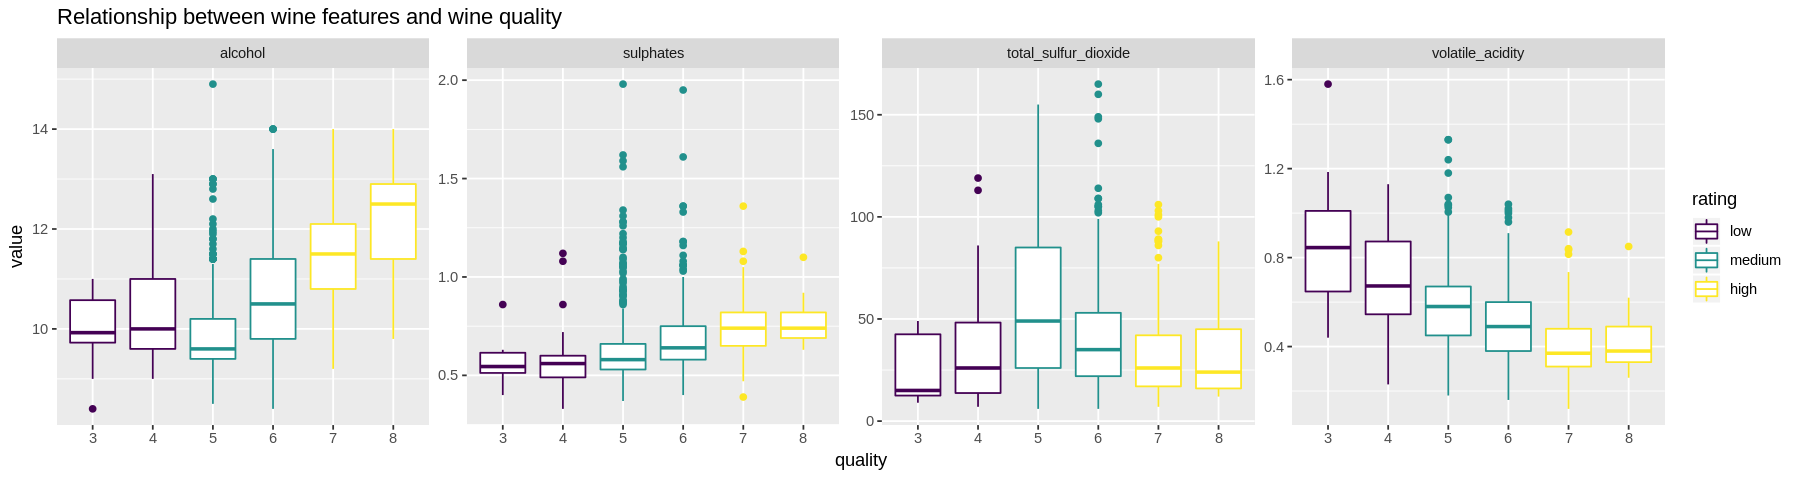

In [690]:
options(repr.plot.width = 15, repr.plot.height = 4)

plt <- wine %>% gather(-c(quality,rating, density,chlorides,fixed_acidity,pH,citric_acid,residual_sugar,free_sulfur_dioxide), key = "var", value = "value") %>% 
  ggplot(aes(x = quality, y = value, color = rating, title = 'c')) +
    geom_boxplot() +
    facet_wrap(~ var, scales = "free", ncol = 4)+
    theme(legend.position="right")

plt + ggtitle('Relationship between wine features and wine quality')


dev.copy(png,"boxplot_sig_features.png", width = 800, height = 300)
dev.off()